# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 933us/sample - loss: 260.2396 - y1_output_loss: 116.3045 - y2_output_loss: 141.7719 - y1_output_root_mean_squared_error: 10.8318 - y2_output_root_mean_squared_error: 11.9546 - val_loss: 35.3948 - val_y1_output_loss: 16.4209 - val_y2_output_loss: 17.8347 - val_y1_output_root_mean_squared_error: 4.1291 - val_y2_output_root_mean_squared_error: 4.2831
Epoch 2/500
614/614 [==============================] - 0s 157us/sample - loss: 30.4754 - y1_output_loss: 11.9010 - y2_output_loss: 18.3773 - y1_output_root_mean_squared_error: 3.4603 - y2_output_root_mean_squared_error: 4.3014 - val_loss: 35.0106 - val_y1_output_loss: 13.6839 - val_y2_output_loss: 20.0757 - val_y1_output_root_mean_squared_error: 3.7686 - val_y2_output_root_mean_squared_error: 4.5616
Epoch 3/500
614/614 [==============================] - 0s 140us/sample - loss: 28.0076 - y1_output_loss: 10.6282 - y2_output_loss: 17.3354 - y1

614/614 [==============================] - 0s 134us/sample - loss: 12.8436 - y1_output_loss: 5.2837 - y2_output_loss: 7.6482 - y1_output_root_mean_squared_error: 2.2838 - y2_output_root_mean_squared_error: 2.7619 - val_loss: 21.5644 - val_y1_output_loss: 8.9033 - val_y2_output_loss: 12.1194 - val_y1_output_root_mean_squared_error: 3.0225 - val_y2_output_root_mean_squared_error: 3.5255
Epoch 22/500
614/614 [==============================] - 0s 134us/sample - loss: 13.7364 - y1_output_loss: 5.3526 - y2_output_loss: 8.5148 - y1_output_root_mean_squared_error: 2.3117 - y2_output_root_mean_squared_error: 2.8970 - val_loss: 11.7118 - val_y1_output_loss: 5.2138 - val_y2_output_loss: 6.1980 - val_y1_output_root_mean_squared_error: 2.3178 - val_y2_output_root_mean_squared_error: 2.5179
Epoch 23/500
614/614 [==============================] - 0s 134us/sample - loss: 13.3473 - y1_output_loss: 5.0669 - y2_output_loss: 8.3333 - y1_output_root_mean_squared_error: 2.2530 - y2_output_root_mean_squared_

Epoch 42/500
614/614 [==============================] - 0s 134us/sample - loss: 7.7382 - y1_output_loss: 2.6025 - y2_output_loss: 5.0949 - y1_output_root_mean_squared_error: 1.6122 - y2_output_root_mean_squared_error: 2.2670 - val_loss: 9.1157 - val_y1_output_loss: 2.6841 - val_y2_output_loss: 6.1383 - val_y1_output_root_mean_squared_error: 1.6682 - val_y2_output_root_mean_squared_error: 2.5165
Epoch 43/500
614/614 [==============================] - 0s 139us/sample - loss: 6.9756 - y1_output_loss: 2.4308 - y2_output_loss: 4.5097 - y1_output_root_mean_squared_error: 1.5647 - y2_output_root_mean_squared_error: 2.1278 - val_loss: 7.5484 - val_y1_output_loss: 2.0575 - val_y2_output_loss: 5.2417 - val_y1_output_root_mean_squared_error: 1.4606 - val_y2_output_root_mean_squared_error: 2.3271
Epoch 44/500
614/614 [==============================] - 0s 137us/sample - loss: 6.2814 - y1_output_loss: 2.3085 - y2_output_loss: 3.9598 - y1_output_root_mean_squared_error: 1.5201 - y2_output_root_mean_s

Epoch 63/500
614/614 [==============================] - 0s 149us/sample - loss: 5.5413 - y1_output_loss: 1.5311 - y2_output_loss: 3.9755 - y1_output_root_mean_squared_error: 1.2418 - y2_output_root_mean_squared_error: 1.9998 - val_loss: 5.9475 - val_y1_output_loss: 1.4279 - val_y2_output_loss: 4.3194 - val_y1_output_root_mean_squared_error: 1.2173 - val_y2_output_root_mean_squared_error: 2.1132
Epoch 64/500
614/614 [==============================] - 0s 142us/sample - loss: 9.0526 - y1_output_loss: 2.7785 - y2_output_loss: 6.2252 - y1_output_root_mean_squared_error: 1.6694 - y2_output_root_mean_squared_error: 2.5032 - val_loss: 5.0612 - val_y1_output_loss: 1.3030 - val_y2_output_loss: 3.6029 - val_y1_output_root_mean_squared_error: 1.1597 - val_y2_output_root_mean_squared_error: 1.9278
Epoch 65/500
614/614 [==============================] - 0s 142us/sample - loss: 4.7519 - y1_output_loss: 1.4426 - y2_output_loss: 3.3192 - y1_output_root_mean_squared_error: 1.2061 - y2_output_root_mean_s

Epoch 84/500
614/614 [==============================] - 0s 139us/sample - loss: 2.8524 - y1_output_loss: 0.6446 - y2_output_loss: 2.2036 - y1_output_root_mean_squared_error: 0.8062 - y2_output_root_mean_squared_error: 1.4841 - val_loss: 9.1685 - val_y1_output_loss: 2.1549 - val_y2_output_loss: 7.2617 - val_y1_output_root_mean_squared_error: 1.4318 - val_y2_output_root_mean_squared_error: 2.6681
Epoch 85/500
614/614 [==============================] - 0s 139us/sample - loss: 6.6337 - y1_output_loss: 2.7775 - y2_output_loss: 5.6516 - y1_output_root_mean_squared_error: 1.4672 - y2_output_root_mean_squared_error: 2.1168 - val_loss: 340.1130 - val_y1_output_loss: 122.4514 - val_y2_output_loss: 225.6777 - val_y1_output_root_mean_squared_error: 10.8534 - val_y2_output_root_mean_squared_error: 14.9103
Epoch 86/500
614/614 [==============================] - 0s 131us/sample - loss: 13.6037 - y1_output_loss: 5.0440 - y2_output_loss: 8.4389 - y1_output_root_mean_squared_error: 2.2562 - y2_output_ro

Epoch 105/500
614/614 [==============================] - 0s 142us/sample - loss: 2.1985 - y1_output_loss: 0.5109 - y2_output_loss: 1.7142 - y1_output_root_mean_squared_error: 0.7172 - y2_output_root_mean_squared_error: 1.2977 - val_loss: 7.0969 - val_y1_output_loss: 0.6142 - val_y2_output_loss: 6.2809 - val_y1_output_root_mean_squared_error: 0.7959 - val_y2_output_root_mean_squared_error: 2.5423
Epoch 106/500
614/614 [==============================] - 0s 137us/sample - loss: 2.5623 - y1_output_loss: 0.6029 - y2_output_loss: 1.9400 - y1_output_root_mean_squared_error: 0.7792 - y2_output_root_mean_squared_error: 1.3983 - val_loss: 3.3612 - val_y1_output_loss: 0.5368 - val_y2_output_loss: 2.7390 - val_y1_output_root_mean_squared_error: 0.7415 - val_y2_output_root_mean_squared_error: 1.6768
Epoch 107/500
614/614 [==============================] - 0s 135us/sample - loss: 2.6689 - y1_output_loss: 0.6228 - y2_output_loss: 2.0453 - y1_output_root_mean_squared_error: 0.7859 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 2.0336 - y1_output_loss: 0.4755 - y2_output_loss: 1.5503 - y1_output_root_mean_squared_error: 0.6897 - y2_output_root_mean_squared_error: 1.2481 - val_loss: 3.0294 - val_y1_output_loss: 0.3920 - val_y2_output_loss: 2.6301 - val_y1_output_root_mean_squared_error: 0.6235 - val_y2_output_root_mean_squared_error: 1.6250
Epoch 126/500
614/614 [==============================] - 0s 135us/sample - loss: 2.0510 - y1_output_loss: 0.4965 - y2_output_loss: 1.5533 - y1_output_root_mean_squared_error: 0.7047 - y2_output_root_mean_squared_error: 1.2467 - val_loss: 3.5012 - val_y1_output_loss: 0.7702 - val_y2_output_loss: 2.7199 - val_y1_output_root_mean_squared_error: 0.8726 - val_y2_output_root_mean_squared_error: 1.6552
Epoch 127/500
614/614 [==============================] - 0s 136us/sample - loss: 2.0421 - y1_output_loss: 0.4451 - y2_output_loss: 1.5802 - y1_output_root_mean_squared_error: 0.6699 - y2_output_root_mean_squared_erro

Epoch 146/500
614/614 [==============================] - 0s 138us/sample - loss: 2.0141 - y1_output_loss: 0.4540 - y2_output_loss: 1.5477 - y1_output_root_mean_squared_error: 0.6738 - y2_output_root_mean_squared_error: 1.2491 - val_loss: 2.5913 - val_y1_output_loss: 0.3119 - val_y2_output_loss: 2.2345 - val_y1_output_root_mean_squared_error: 0.5645 - val_y2_output_root_mean_squared_error: 1.5075
Epoch 147/500
614/614 [==============================] - 0s 140us/sample - loss: 1.8079 - y1_output_loss: 0.3597 - y2_output_loss: 1.4356 - y1_output_root_mean_squared_error: 0.6024 - y2_output_root_mean_squared_error: 1.2021 - val_loss: 3.4550 - val_y1_output_loss: 0.6659 - val_y2_output_loss: 2.9034 - val_y1_output_root_mean_squared_error: 0.7819 - val_y2_output_root_mean_squared_error: 1.6863
Epoch 148/500
614/614 [==============================] - 0s 136us/sample - loss: 1.7884 - y1_output_loss: 0.3410 - y2_output_loss: 1.4358 - y1_output_root_mean_squared_error: 0.5852 - y2_output_root_mea

614/614 [==============================] - 0s 152us/sample - loss: 1.3889 - y1_output_loss: 0.3020 - y2_output_loss: 1.0914 - y1_output_root_mean_squared_error: 0.5515 - y2_output_root_mean_squared_error: 1.0415 - val_loss: 3.3473 - val_y1_output_loss: 0.3268 - val_y2_output_loss: 2.9596 - val_y1_output_root_mean_squared_error: 0.5655 - val_y2_output_root_mean_squared_error: 1.7400
Epoch 167/500
614/614 [==============================] - 0s 167us/sample - loss: 1.4978 - y1_output_loss: 0.3638 - y2_output_loss: 1.1321 - y1_output_root_mean_squared_error: 0.5976 - y2_output_root_mean_squared_error: 1.0680 - val_loss: 3.2872 - val_y1_output_loss: 0.6365 - val_y2_output_loss: 2.6731 - val_y1_output_root_mean_squared_error: 0.7783 - val_y2_output_root_mean_squared_error: 1.6375
Epoch 168/500
614/614 [==============================] - 0s 136us/sample - loss: 1.5895 - y1_output_loss: 0.3564 - y2_output_loss: 1.2314 - y1_output_root_mean_squared_error: 0.5964 - y2_output_root_mean_squared_erro

Epoch 187/500
614/614 [==============================] - 0s 136us/sample - loss: 1.6960 - y1_output_loss: 0.3934 - y2_output_loss: 1.2889 - y1_output_root_mean_squared_error: 0.6299 - y2_output_root_mean_squared_error: 1.1398 - val_loss: 2.3076 - val_y1_output_loss: 0.2808 - val_y2_output_loss: 2.0007 - val_y1_output_root_mean_squared_error: 0.5263 - val_y2_output_root_mean_squared_error: 1.4250
Epoch 188/500
614/614 [==============================] - 0s 139us/sample - loss: 1.5209 - y1_output_loss: 0.3751 - y2_output_loss: 1.1577 - y1_output_root_mean_squared_error: 0.6045 - y2_output_root_mean_squared_error: 1.0749 - val_loss: 2.7808 - val_y1_output_loss: 0.2890 - val_y2_output_loss: 2.4119 - val_y1_output_root_mean_squared_error: 0.5473 - val_y2_output_root_mean_squared_error: 1.5752
Epoch 189/500
614/614 [==============================] - 0s 136us/sample - loss: 1.3505 - y1_output_loss: 0.2702 - y2_output_loss: 1.0753 - y1_output_root_mean_squared_error: 0.5183 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 1.4284 - y1_output_loss: 0.3269 - y2_output_loss: 1.0930 - y1_output_root_mean_squared_error: 0.5729 - y2_output_root_mean_squared_error: 1.0489 - val_loss: 2.4918 - val_y1_output_loss: 0.2809 - val_y2_output_loss: 2.2217 - val_y1_output_root_mean_squared_error: 0.5145 - val_y2_output_root_mean_squared_error: 1.4924
Epoch 208/500
614/614 [==============================] - 0s 144us/sample - loss: 1.3300 - y1_output_loss: 0.3013 - y2_output_loss: 1.0188 - y1_output_root_mean_squared_error: 0.5514 - y2_output_root_mean_squared_error: 1.0129 - val_loss: 2.2717 - val_y1_output_loss: 0.2415 - val_y2_output_loss: 2.0281 - val_y1_output_root_mean_squared_error: 0.4782 - val_y2_output_root_mean_squared_error: 1.4293
Epoch 209/500
614/614 [==============================] - 0s 143us/sample - loss: 1.1814 - y1_output_loss: 0.2249 - y2_output_loss: 0.9474 - y1_output_root_mean_squared_error: 0.4763 - y2_output_root_mean_squared_erro

Epoch 228/500
614/614 [==============================] - 0s 138us/sample - loss: 1.1557 - y1_output_loss: 0.2629 - y2_output_loss: 0.8943 - y1_output_root_mean_squared_error: 0.5086 - y2_output_root_mean_squared_error: 0.9471 - val_loss: 3.7643 - val_y1_output_loss: 1.1280 - val_y2_output_loss: 2.7404 - val_y1_output_root_mean_squared_error: 1.0357 - val_y2_output_root_mean_squared_error: 1.6406
Epoch 229/500
614/614 [==============================] - 0s 132us/sample - loss: 1.3494 - y1_output_loss: 0.2695 - y2_output_loss: 1.0779 - y1_output_root_mean_squared_error: 0.5171 - y2_output_root_mean_squared_error: 1.0402 - val_loss: 2.1368 - val_y1_output_loss: 0.3594 - val_y2_output_loss: 1.7301 - val_y1_output_root_mean_squared_error: 0.6105 - val_y2_output_root_mean_squared_error: 1.3282
Epoch 230/500
614/614 [==============================] - 0s 131us/sample - loss: 1.2984 - y1_output_loss: 0.2829 - y2_output_loss: 1.0084 - y1_output_root_mean_squared_error: 0.5341 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 1.3126 - y1_output_loss: 0.2646 - y2_output_loss: 1.0415 - y1_output_root_mean_squared_error: 0.5163 - y2_output_root_mean_squared_error: 1.0228 - val_loss: 1.9346 - val_y1_output_loss: 0.1747 - val_y2_output_loss: 1.7497 - val_y1_output_root_mean_squared_error: 0.4150 - val_y2_output_root_mean_squared_error: 1.3276
Epoch 249/500
614/614 [==============================] - 0s 132us/sample - loss: 0.9349 - y1_output_loss: 0.2106 - y2_output_loss: 0.7211 - y1_output_root_mean_squared_error: 0.4599 - y2_output_root_mean_squared_error: 0.8505 - val_loss: 2.1293 - val_y1_output_loss: 0.3043 - val_y2_output_loss: 1.8914 - val_y1_output_root_mean_squared_error: 0.5077 - val_y2_output_root_mean_squared_error: 1.3680
Epoch 250/500
614/614 [==============================] - 0s 144us/sample - loss: 0.8720 - y1_output_loss: 0.2083 - y2_output_loss: 0.6602 - y1_output_root_mean_squared_error: 0.4533 - y2_output_root_mean_squared_erro

Epoch 269/500
614/614 [==============================] - 0s 142us/sample - loss: 0.8716 - y1_output_loss: 0.1956 - y2_output_loss: 0.6800 - y1_output_root_mean_squared_error: 0.4438 - y2_output_root_mean_squared_error: 0.8213 - val_loss: 3.1919 - val_y1_output_loss: 0.3737 - val_y2_output_loss: 2.8637 - val_y1_output_root_mean_squared_error: 0.5891 - val_y2_output_root_mean_squared_error: 1.6866
Epoch 270/500
614/614 [==============================] - 0s 140us/sample - loss: 1.1506 - y1_output_loss: 0.2894 - y2_output_loss: 0.8587 - y1_output_root_mean_squared_error: 0.5395 - y2_output_root_mean_squared_error: 0.9271 - val_loss: 1.7449 - val_y1_output_loss: 0.1495 - val_y2_output_loss: 1.5701 - val_y1_output_root_mean_squared_error: 0.3813 - val_y2_output_root_mean_squared_error: 1.2647
Epoch 271/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7741 - y1_output_loss: 0.1834 - y2_output_loss: 0.5866 - y1_output_root_mean_squared_error: 0.4286 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.8720 - y1_output_loss: 0.2105 - y2_output_loss: 0.6587 - y1_output_root_mean_squared_error: 0.4595 - y2_output_root_mean_squared_error: 0.8130 - val_loss: 1.8240 - val_y1_output_loss: 0.2354 - val_y2_output_loss: 1.6100 - val_y1_output_root_mean_squared_error: 0.4622 - val_y2_output_root_mean_squared_error: 1.2690
Epoch 290/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8138 - y1_output_loss: 0.1689 - y2_output_loss: 0.6417 - y1_output_root_mean_squared_error: 0.4104 - y2_output_root_mean_squared_error: 0.8033 - val_loss: 1.7067 - val_y1_output_loss: 0.1674 - val_y2_output_loss: 1.5040 - val_y1_output_root_mean_squared_error: 0.4099 - val_y2_output_root_mean_squared_error: 1.2404
Epoch 291/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9386 - y1_output_loss: 0.2699 - y2_output_loss: 0.8018 - y1_output_root_mean_squared_error: 0.4596 - y2_output_root_mean_squared_erro

Epoch 310/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9041 - y1_output_loss: 0.2292 - y2_output_loss: 0.6687 - y1_output_root_mean_squared_error: 0.4810 - y2_output_root_mean_squared_error: 0.8202 - val_loss: 2.2336 - val_y1_output_loss: 0.4130 - val_y2_output_loss: 1.7538 - val_y1_output_root_mean_squared_error: 0.6503 - val_y2_output_root_mean_squared_error: 1.3456
Epoch 311/500
614/614 [==============================] - 0s 132us/sample - loss: 0.9231 - y1_output_loss: 0.2051 - y2_output_loss: 0.7174 - y1_output_root_mean_squared_error: 0.4534 - y2_output_root_mean_squared_error: 0.8471 - val_loss: 2.3271 - val_y1_output_loss: 0.3195 - val_y2_output_loss: 1.9379 - val_y1_output_root_mean_squared_error: 0.5755 - val_y2_output_root_mean_squared_error: 1.4128
Epoch 312/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6988 - y1_output_loss: 0.1777 - y2_output_loss: 0.5164 - y1_output_root_mean_squared_error: 0.4228 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 1.0355 - y1_output_loss: 0.2405 - y2_output_loss: 0.7892 - y1_output_root_mean_squared_error: 0.4922 - y2_output_root_mean_squared_error: 0.8906 - val_loss: 1.6659 - val_y1_output_loss: 0.1691 - val_y2_output_loss: 1.4744 - val_y1_output_root_mean_squared_error: 0.4121 - val_y2_output_root_mean_squared_error: 1.2231
Epoch 331/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7171 - y1_output_loss: 0.1773 - y2_output_loss: 0.5337 - y1_output_root_mean_squared_error: 0.4225 - y2_output_root_mean_squared_error: 0.7339 - val_loss: 1.7051 - val_y1_output_loss: 0.2157 - val_y2_output_loss: 1.5042 - val_y1_output_root_mean_squared_error: 0.4526 - val_y2_output_root_mean_squared_error: 1.2248
Epoch 332/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8372 - y1_output_loss: 0.1906 - y2_output_loss: 0.6415 - y1_output_root_mean_squared_error: 0.4373 - y2_output_root_mean_squared_erro

Epoch 351/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5907 - y1_output_loss: 0.1668 - y2_output_loss: 0.4242 - y1_output_root_mean_squared_error: 0.4054 - y2_output_root_mean_squared_error: 0.6530 - val_loss: 1.6178 - val_y1_output_loss: 0.2376 - val_y2_output_loss: 1.3501 - val_y1_output_root_mean_squared_error: 0.4941 - val_y2_output_root_mean_squared_error: 1.1720
Epoch 352/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7164 - y1_output_loss: 0.1744 - y2_output_loss: 0.5397 - y1_output_root_mean_squared_error: 0.4192 - y2_output_root_mean_squared_error: 0.7353 - val_loss: 1.3895 - val_y1_output_loss: 0.1629 - val_y2_output_loss: 1.2310 - val_y1_output_root_mean_squared_error: 0.3898 - val_y2_output_root_mean_squared_error: 1.1125
Epoch 353/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8186 - y1_output_loss: 0.1991 - y2_output_loss: 0.6123 - y1_output_root_mean_squared_error: 0.4478 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 0.5734 - y1_output_loss: 0.1507 - y2_output_loss: 0.4193 - y1_output_root_mean_squared_error: 0.3898 - y2_output_root_mean_squared_error: 0.6492 - val_loss: 1.4003 - val_y1_output_loss: 0.1408 - val_y2_output_loss: 1.2559 - val_y1_output_root_mean_squared_error: 0.3644 - val_y2_output_root_mean_squared_error: 1.1258
Epoch 372/500
614/614 [==============================] - 0s 136us/sample - loss: 0.7277 - y1_output_loss: 0.1730 - y2_output_loss: 0.5560 - y1_output_root_mean_squared_error: 0.4151 - y2_output_root_mean_squared_error: 0.7452 - val_loss: 1.9213 - val_y1_output_loss: 0.1482 - val_y2_output_loss: 1.7360 - val_y1_output_root_mean_squared_error: 0.3845 - val_y2_output_root_mean_squared_error: 1.3317
Epoch 373/500
614/614 [==============================] - 0s 134us/sample - loss: 0.6179 - y1_output_loss: 0.1748 - y2_output_loss: 0.4422 - y1_output_root_mean_squared_error: 0.4183 - y2_output_root_mean_squared_erro

Epoch 392/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5626 - y1_output_loss: 0.1619 - y2_output_loss: 0.3991 - y1_output_root_mean_squared_error: 0.4031 - y2_output_root_mean_squared_error: 0.6325 - val_loss: 1.5023 - val_y1_output_loss: 0.1482 - val_y2_output_loss: 1.3477 - val_y1_output_root_mean_squared_error: 0.3766 - val_y2_output_root_mean_squared_error: 1.1664
Epoch 393/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4960 - y1_output_loss: 0.1410 - y2_output_loss: 0.3565 - y1_output_root_mean_squared_error: 0.3759 - y2_output_root_mean_squared_error: 0.5956 - val_loss: 1.3477 - val_y1_output_loss: 0.1421 - val_y2_output_loss: 1.1908 - val_y1_output_root_mean_squared_error: 0.3780 - val_y2_output_root_mean_squared_error: 1.0977
Epoch 394/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5979 - y1_output_loss: 0.1567 - y2_output_loss: 0.4484 - y1_output_root_mean_squared_error: 0.3964 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.6570 - y1_output_loss: 0.1727 - y2_output_loss: 0.4797 - y1_output_root_mean_squared_error: 0.4160 - y2_output_root_mean_squared_error: 0.6957 - val_loss: 1.4705 - val_y1_output_loss: 0.2515 - val_y2_output_loss: 1.2461 - val_y1_output_root_mean_squared_error: 0.4752 - val_y2_output_root_mean_squared_error: 1.1157
Epoch 413/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5061 - y1_output_loss: 0.1334 - y2_output_loss: 0.3708 - y1_output_root_mean_squared_error: 0.3658 - y2_output_root_mean_squared_error: 0.6101 - val_loss: 1.2696 - val_y1_output_loss: 0.1388 - val_y2_output_loss: 1.1188 - val_y1_output_root_mean_squared_error: 0.3656 - val_y2_output_root_mean_squared_error: 1.0658
Epoch 414/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5739 - y1_output_loss: 0.1613 - y2_output_loss: 0.4089 - y1_output_root_mean_squared_error: 0.4021 - y2_output_root_mean_squared_erro

Epoch 433/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4891 - y1_output_loss: 0.1505 - y2_output_loss: 0.3378 - y1_output_root_mean_squared_error: 0.3864 - y2_output_root_mean_squared_error: 0.5829 - val_loss: 1.3730 - val_y1_output_loss: 0.1675 - val_y2_output_loss: 1.2279 - val_y1_output_root_mean_squared_error: 0.3885 - val_y2_output_root_mean_squared_error: 1.1055
Epoch 434/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4720 - y1_output_loss: 0.1434 - y2_output_loss: 0.3259 - y1_output_root_mean_squared_error: 0.3793 - y2_output_root_mean_squared_error: 0.5728 - val_loss: 1.1138 - val_y1_output_loss: 0.1491 - val_y2_output_loss: 0.9586 - val_y1_output_root_mean_squared_error: 0.3804 - val_y2_output_root_mean_squared_error: 0.9844
Epoch 435/500
614/614 [==============================] - 0s 159us/sample - loss: 0.4929 - y1_output_loss: 0.1409 - y2_output_loss: 0.3520 - y1_output_root_mean_squared_error: 0.3768 - y2_output_root_mea

614/614 [==============================] - 0s 146us/sample - loss: 0.5793 - y1_output_loss: 0.1707 - y2_output_loss: 0.4108 - y1_output_root_mean_squared_error: 0.4124 - y2_output_root_mean_squared_error: 0.6397 - val_loss: 1.9625 - val_y1_output_loss: 0.2778 - val_y2_output_loss: 1.7682 - val_y1_output_root_mean_squared_error: 0.4879 - val_y2_output_root_mean_squared_error: 1.3132
Epoch 454/500
614/614 [==============================] - 0s 137us/sample - loss: 0.5286 - y1_output_loss: 0.1533 - y2_output_loss: 0.3742 - y1_output_root_mean_squared_error: 0.3905 - y2_output_root_mean_squared_error: 0.6132 - val_loss: 1.4102 - val_y1_output_loss: 0.1962 - val_y2_output_loss: 1.1979 - val_y1_output_root_mean_squared_error: 0.4346 - val_y2_output_root_mean_squared_error: 1.1051
Epoch 455/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5365 - y1_output_loss: 0.1349 - y2_output_loss: 0.4081 - y1_output_root_mean_squared_error: 0.3536 - y2_output_root_mean_squared_erro

Epoch 474/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4189 - y1_output_loss: 0.1321 - y2_output_loss: 0.2867 - y1_output_root_mean_squared_error: 0.3613 - y2_output_root_mean_squared_error: 0.5370 - val_loss: 1.1712 - val_y1_output_loss: 0.1868 - val_y2_output_loss: 1.0135 - val_y1_output_root_mean_squared_error: 0.4054 - val_y2_output_root_mean_squared_error: 1.0034
Epoch 475/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5298 - y1_output_loss: 0.1434 - y2_output_loss: 0.3833 - y1_output_root_mean_squared_error: 0.3805 - y2_output_root_mean_squared_error: 0.6205 - val_loss: 1.1039 - val_y1_output_loss: 0.1538 - val_y2_output_loss: 0.9584 - val_y1_output_root_mean_squared_error: 0.3778 - val_y2_output_root_mean_squared_error: 0.9804
Epoch 476/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5606 - y1_output_loss: 0.1545 - y2_output_loss: 0.4055 - y1_output_root_mean_squared_error: 0.3939 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.4149 - y1_output_loss: 0.1253 - y2_output_loss: 0.2908 - y1_output_root_mean_squared_error: 0.3545 - y2_output_root_mean_squared_error: 0.5378 - val_loss: 1.1487 - val_y1_output_loss: 0.1454 - val_y2_output_loss: 0.9813 - val_y1_output_root_mean_squared_error: 0.3776 - val_y2_output_root_mean_squared_error: 1.0030
Epoch 495/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4733 - y1_output_loss: 0.1308 - y2_output_loss: 0.3401 - y1_output_root_mean_squared_error: 0.3624 - y2_output_root_mean_squared_error: 0.5848 - val_loss: 1.1949 - val_y1_output_loss: 0.1937 - val_y2_output_loss: 1.0286 - val_y1_output_root_mean_squared_error: 0.4186 - val_y2_output_root_mean_squared_error: 1.0098
Epoch 496/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5606 - y1_output_loss: 0.1765 - y2_output_loss: 0.3809 - y1_output_root_mean_squared_error: 0.4209 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 37us/sample - loss: 1.0716 - y1_output_loss: 0.1684 - y2_output_loss: 0.9105 - y1_output_root_mean_squared_error: 0.4094 - y2_output_root_mean_squared_error: 0.9508
Loss = 1.071644443970222, Y1_loss = 0.16839179396629333, Y1_mse = 0.4093616008758545, Y2_loss = 0.9104987382888794, Y2_mse = 0.9508246779441833


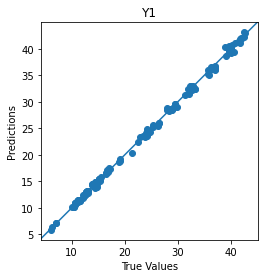

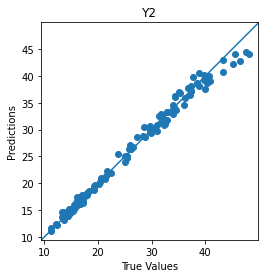

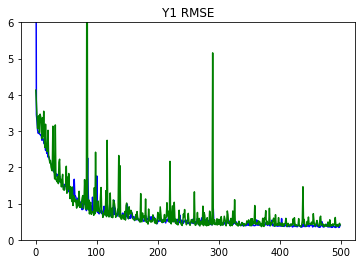

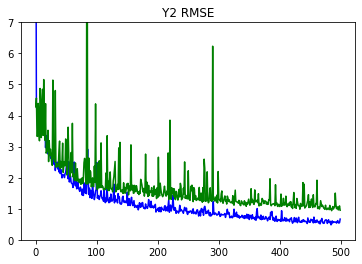

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)